In [10]:
import sympy as sp
import numpy as np
from sympy.functions import sec, tan

# q1:theta q2:positionx
# ───────────── 1. Variables ─────────────────────────
m, M, g = sp.symbols('m M g', positive=True)  
l = sp.symbols('l', positive=True)        # Pendulum length (0.37~0.7 m)
b = 1/l                                   # b = 1/l
a=g/l
k, P, k_v = sp.symbols('k P k_v', positive=True)
m22_0 = sp.symbols('m22_0', positive=True)
# M_I = sp.Matrix([[1,0], [0,1]])  # Inertia matrix
M_I = sp.eye(2)      # Identity


# ------- X PARAMETERS and RELATED -------
theta,x = sp.symbols('theta x')               # pendulum anlge
c = sp.cos(theta)

x_star = sp.symbols('x_star')        # cart position, desired position
dtheta,dx = sp.symbols('dtheta dx')       # derivatives of q1 and q2

q = sp.Matrix([theta, x])  # State vector
# M_I = sp.Matrix([[1, b*sp.cos(q[0])], [b*sp.cos(q[0]), (M+m)/(m*l**2)]])  # Inertia matrix
V=(g/l)*sp.cos(q[0])

p  = sp.Matrix([dtheta, dx])

# ───────────── 2. inertial matrix  M_d(θ) ────────────────
Md = sp.Matrix([[ k*b**2/3 * c**3,   -k*b/2 * c**2 ],
                [ -k*b/2 * c**2,      k*c + m22_0   ]])
Md_inv = Md.inv()
# Md's derivative related to θ 
Md_p = Md.diff(theta)

# ───────────── 3. F(θ)and its derivative with α(θ) ─────────────────
F = 3*l*sp.log( sp.sec(theta) + sp.tan(theta)) + 6*l*m22_0/k * sp.tan(theta)
F_p = sp.diff(F, theta)  # F'(θ)

alpha_coeff = -k**2 * c**3 * sp.sin(theta)/(12*l**2)
alpha1 = alpha_coeff * sp.Matrix([ [ c/l ], [-1] ])   # (2×1)




# ───────────── 4. A1 ~ A4  (equation 12a–12d) ─────────────────
#A1(θ)
m11, m12, m22 = Md[0,0], Md[0,1], Md[1,1]
A1 = -( m12*F_p + m22 )                               # (12a)


# bracket = sp.Matrix([[sp.diff(m11,theta)-alpha1[0], sp.diff(m12,theta) ],[sp.diff(m12,theta)-alpha1[1],sp.diff(m22,theta)]])  # (12b)

bracket = sp.Matrix([
    [sp.diff(m11, theta) - alpha1[0], sp.diff(m12, theta)],
    [sp.diff(m12, theta)            , sp.diff(m22, theta) - alpha1[1]]  # Symmetrized
])
A2 = -0.5 * m12 * Md_inv * bracket *  Md_inv
A3 = -m12 * (6*a*sp.sin(theta)) / (k*b**2*c**3) + P*F*A1
A4 = sp.Matrix([[-c/l, 1]]) * Md_inv                 # (12d)

# ───────────── 5.desired potential energy V_d(q)  ──────────── 
V_d = 3*g*l / (k* c**2) + P/2*(x-x_star+F)**2      #    

# ───────────── 6. Control output u ─────────────────────
#∂V_d/∂q
q_vec = sp.Matrix([theta, x])
dVd_dq = sp.Matrix([sp.diff(V_d, theta), sp.diff(V_d, x)])

FactorA1 = A1*P*(x-x_star)
FactorA2 = (p.T*A2*p)[0,0]
FactorA3 = A3
FactorA4 = -k_v * (A4 * p)[0,0]

# Control output u (eq 13)
u = FactorA1 + FactorA2 + FactorA3 + FactorA4
ddq = a * sp.sin(q[0])*sp.Matrix([1, 0]) + sp.Matrix([-b*c, 1]) * u

Minv = M_I.inv()
H = sp.Rational(1,2) * (p.T * Minv * p)[0] + V   # [0] to extract scalar
Hd = 0.5*(p.T*Md_inv*p)[0] + V_d


params = {
    l:1, k:0.01, P:1, m22_0:0.01, k_v:0.01, x_star:20,
    m:11, M:3.0, g:1       
}

# Lambdas (after your params dict)
u_num      = sp.lambdify((theta, x, dtheta, dx), u.subs(params), 'numpy')
ddq_num    = sp.lambdify((theta, x, dtheta, dx), ddq.subs(params), 'numpy')

# numeric mass matrix
M_I_num = sp.lambdify((theta, x, m, M, g, l), M_I, 'numpy')

def nu_func(theta_val, x_val, dtheta_val, dx_val):
    ddq = ddq_num(theta_val, x_val, dtheta_val, dx_val)
    return ddq[0], ddq[1]



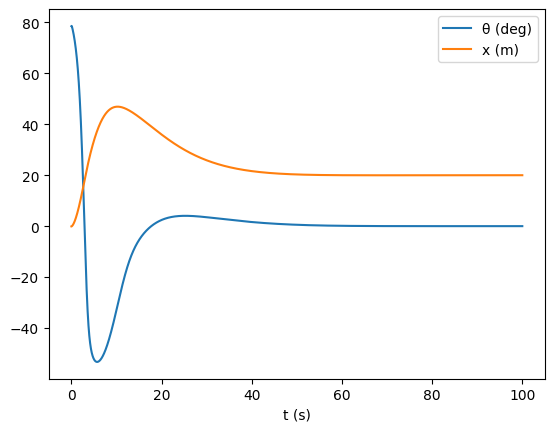

In [11]:
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

# pull numeric params from your dict
m_val = float(params[m]); M_val = float(params[M])
g_val = float(params[g]); l_val = float(params[l])
a_val = g_val / l_val
b_val = 1.0 / l_val


# M_I(q): inverse mass matrix function -> numpy 2x2
M_I_num = sp.lambdify((theta, x, m, M, g, l), M_I, 'numpy')



def dynamics_ph(t, z):
    # Unpack the state vector [theta, x, p_theta, p_x]
    th, x, dth, dx = z
    ddth,ddx = nu_func(th, x, dth, dx)
    return [dth, dx, ddth, ddx]



# simulate
T = 100
z0 = np.array([sp.pi/2 - 0.2, -0.1, 0.1, 0], dtype=float)  # [θ, x, pθ, px]
sol = solve_ivp(dynamics_ph, (0, T), z0, t_eval=np.linspace(0, T, 300000),
                rtol=1e-8, atol=1e-10) 


t = sol.t
theta_traj = sol.y[0]   
x_traj = sol.y[1]

plt.plot(t, np.rad2deg(theta_traj), label='θ (deg)')
plt.plot(t, x_traj, label='x (m)')
plt.xlabel('t (s)')
plt.legend()
plt.show()
